## Stochastic Volatility/Jump Diffusion model

$$
\frac{dS}{S} = (\mu − \lambda \bar{k})~dt + \sqrt{V}~dZ + k~dq
$$

$$
dV = (\alpha − \beta V ) dt + \sigma_v \sqrt{V} dZ_v
$$


$$
Corr(dZ, dZ_v) = \rho
$$

$$ 
prob(dq = 1) = \lambda . dt 
$$

$$
ln(1+k) \backsim \phi(ln[1+\bar{k}] - 0.5 \kappa, \kappa^2)
$$

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import plt

In [2]:
np.random.seed(123)

In [3]:
def rng(time_steps, paths):
    rn = np.random.standard_normal((time_steps, paths))
    # Moment Matching
    rn -= rn.mean()
    rn /= rn.std()
    return rn

In [4]:
def rng_corr(time_steps, paths, rho):
    rn1 = rng(time_steps, paths)
    rn2 = rng(time_steps, paths)
    rn2 = rho*rn1 + rn2 * np.sqrt(1 - rho*rho)
    # Moment Matching
    rn2 -= rn2.mean()
    rn2 /= rn2.std()
    return [rn1, rn2] 

In [5]:
def svjd_paths(T, time_steps, paths, alpha, beta, kappa, kbar, lmbda, mu, sigmav, rho):
    size = (time_steps+1, paths)
    dt = T/time_steps
    Z, Zv = rng_corr(time_steps+1, paths, rho)
    s = np.zeros(size)
    v = np.zeros(size)
    y = np.zeros(size)
    k_loc = np.log(1+kbar)-0.5*kappa
    k = np.exp(np.random.normal(loc=k_loc, scale=kappa, size=size)) - 1.
    q = np.random.poisson(lmbda*dt, size)
    
    s[0, :] = mu
    v[0, :] = alpha
    y[0, :] = 0
    for i in range(1, time_steps+1, 1):
        vi = v[i-1, :] + (alpha - beta*v[i-1, :])*dt + sigmav*np.sqrt(v[i-1,:]) * np.sqrt(dt) * Zv[i, :]
        vip = v[i-1, :] + alpha*dt
        v[i, :] = np.where(vi < 0, vip, vi)
       
        s[i, :] = s[i-1, :] * np.exp(((mu - lmbda * kbar) - 0.5*v[i-1, :])*dt + \
                                     np.sqrt(v[i-1, :]) * np.sqrt(dt) * Z[i, :]) + k[i, :] * q[i, :]
        
        y[i,:] = (mu - lmbda * kbar)*dt + np.sqrt(v[i-1, :]) * Z[i,:] + k[i, :] * q[i,:]
            
    return s, v, q, k, y

In [6]:
svjd_prms = {'alpha':.0003, 'beta':.7024, 'kappa':.0281, 'kbar':.30, 'lmbda': 2, 'mu': .2133, 'sigmav':.1179, 'rho': .6}
s_paths, v_paths, q, k, y = svjd_paths(T=500/12, time_steps=500, paths=1, **svjd_prms)

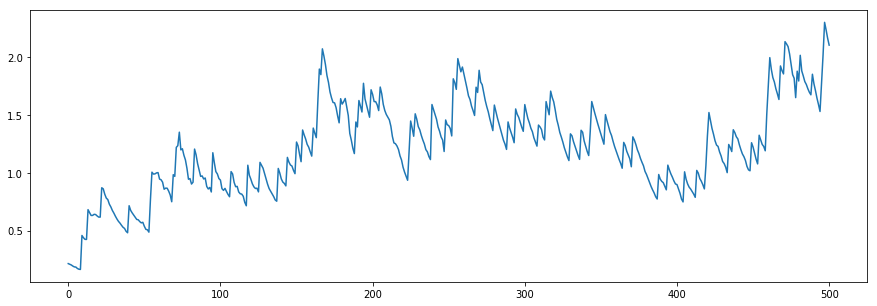

In [7]:
plt.figure(figsize=(15,5))
plt.plot(s_paths[:, 0]);

In [8]:
fdiff_y = y[1:, 0]- y[:-1, 0]
df = pd.DataFrame(fdiff_y, columns=['svjd_model'], index=range(500))

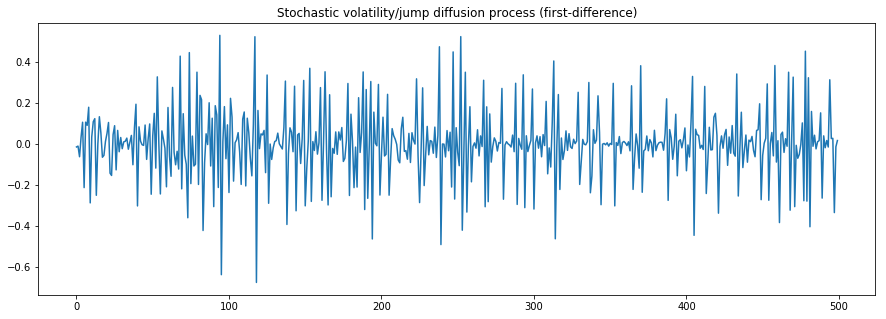

In [9]:
plt.figure(figsize=(15,5))
plt.title('Stochastic volatility/jump diffusion process (first-difference)')
plt.plot(fdiff_y);

In [10]:
lags = 4
cols = []
for lag in range(1,lags+1):
    col = 'lag_%d'% lag
    cols.append(col)
    df[col] = df['svjd_model'].shift(lag)

df = df.dropna(how='any')

In [11]:
Y = df[['svjd_model']].values
X = df[cols].values

test_Y = Y[-100:]
test_X = X[-100:]

train_Y = Y[:-100]
train_X = X[:-100]

## OLS Regression

In [12]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

/home/mehdi/Py36Env/py36env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [13]:
model = sm.OLS(train_Y, train_X)
results = model.fit()
#results.summary()

In [14]:
ols_results = pd.DataFrame(fdiff_y, columns=['model'])
ols_results['in_sample'] = np.nan
ols_results['out_sample'] = np.nan

ols_in_sample = results.fittedvalues.flatten()
ols_out_sample = results.predict(test_X)

ols_results.loc[5:400, 'in_sample'] = results.fittedvalues.flatten()
ols_results.loc[400:, 'out_sample'] = results.predict(test_X)

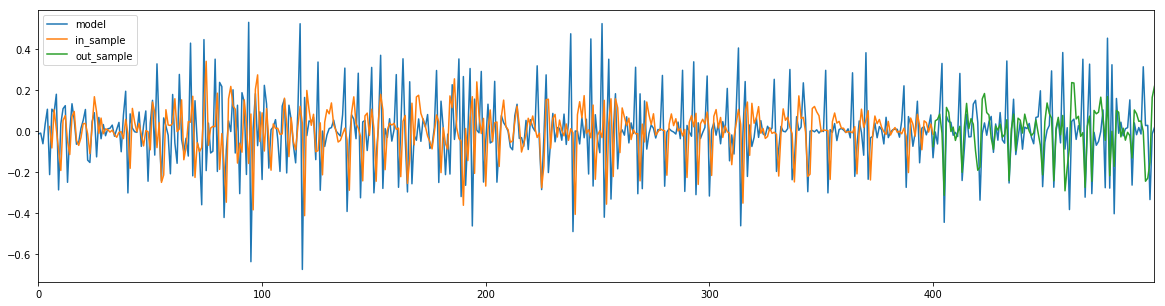

In [15]:
ols_results.plot(figsize=(20, 5));

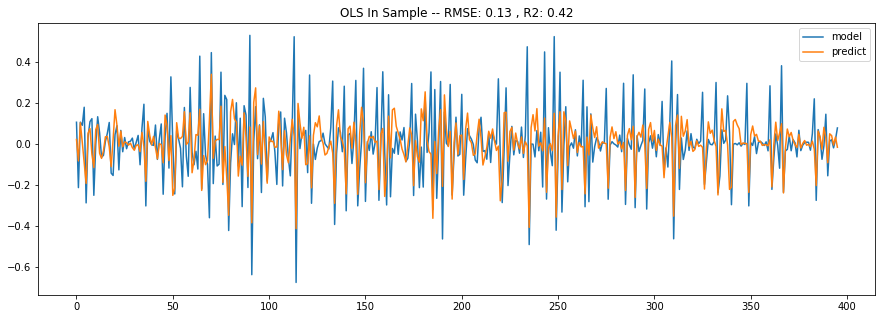

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(train_Y, label='model')
plt.plot(ols_in_sample, label='predict')
# calculate root mean squared error
ols_train_rmse = np.sqrt(mean_squared_error(train_Y.flatten(), ols_in_sample))
plt.title('OLS In Sample -- RMSE: %.2f , R2: %.2f' % (ols_train_rmse, r2_score(train_Y.flatten(), ols_in_sample)))
plt.legend(loc=0)
plt.show()

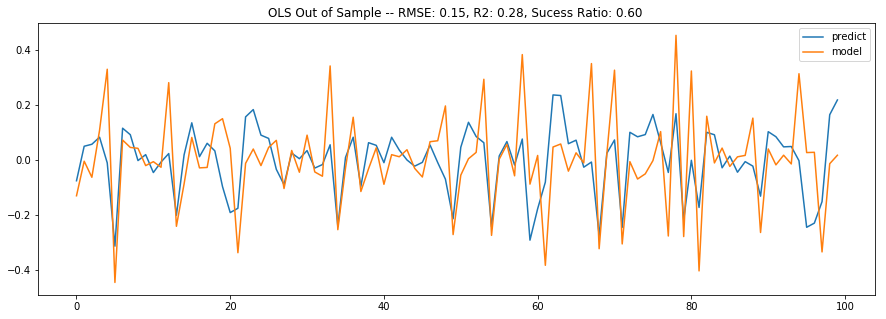

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(ols_out_sample, label='predict')
plt.plot(test_Y, label='model')

# calculate root mean squared error and sucess ratio
success_ratio = lambda a, b: np.mean(np.sign(a)==np.sign(b))

ols_test_rmse = np.sqrt(mean_squared_error(test_Y.flatten(), ols_out_sample))

sr = success_ratio(ols_out_sample, test_Y.flatten())
plt.title('OLS Out of Sample -- RMSE: %.2f, R2: %.2f, Sucess Ratio: %.2f ' % (ols_test_rmse, r2_score(test_Y.flatten(), ols_out_sample), sr))
plt.legend(loc=0)
plt.show()

## Deep Learning with Keras

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.layers.advanced_activations import *
import keras.backend as Kb

Using Theano backend.


In [19]:
def r_coeff(y_true, y_pred):
    rss = Kb.sum(Kb.square(y_true-y_pred))
    sst = Kb.sum(Kb.square(y_true-Kb.mean(y_true)))
    return 1-(rss/(sst+Kb.epsilon()))

In [20]:
def success_ratio(y_true, y_pred):
    return Kb.mean(Kb.equal(Kb.sign(y_true), Kb.sign(y_pred)))

In [21]:
model = Sequential()
model.add(Dense(3, input_dim=lags))
model.add(Activation('tanh'))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('tanh'))
model.compile(loss='mse', optimizer='adam', metrics=[success_ratio, r_coeff])

In [22]:
history = model.fit(train_X, train_Y,
                    epochs=4000, 
                    batch_size=len(train_X), 
                    verbose=2,
                    validation_data=(test_X, test_Y), 
                    shuffle=False, 
                   )

Train on 396 samples, validate on 100 samples
Epoch 1/4000
0s - loss: 0.1831 - success_ratio: 0.3889 - r_coeff: -5.0157e+00 - val_loss: 0.1433 - val_success_ratio: 0.4800 - val_r_coeff: -3.8570e+00
Epoch 2/4000
0s - loss: 0.1824 - success_ratio: 0.3914 - r_coeff: -4.9909e+00 - val_loss: 0.1427 - val_success_ratio: 0.4800 - val_r_coeff: -3.8374e+00
Epoch 3/4000
0s - loss: 0.1816 - success_ratio: 0.3965 - r_coeff: -4.9667e+00 - val_loss: 0.1421 - val_success_ratio: 0.4700 - val_r_coeff: -3.8183e+00
Epoch 4/4000
0s - loss: 0.1809 - success_ratio: 0.3965 - r_coeff: -4.9430e+00 - val_loss: 0.1416 - val_success_ratio: 0.4700 - val_r_coeff: -3.7998e+00
Epoch 5/4000
0s - loss: 0.1802 - success_ratio: 0.3939 - r_coeff: -4.9198e+00 - val_loss: 0.1411 - val_success_ratio: 0.4700 - val_r_coeff: -3.7818e+00
Epoch 6/4000
0s - loss: 0.1795 - success_ratio: 0.3889 - r_coeff: -4.8972e+00 - val_loss: 0.1405 - val_success_ratio: 0.4700 - val_r_coeff: -3.7643e+00
Epoch 7/4000
0s - loss: 0.1788 - success_r

0s - loss: 0.1040 - success_ratio: 0.3889 - r_coeff: -2.4160e+00 - val_loss: 0.0816 - val_success_ratio: 0.4700 - val_r_coeff: -1.7671e+00
Epoch 153/4000
0s - loss: 0.1036 - success_ratio: 0.3889 - r_coeff: -2.4032e+00 - val_loss: 0.0813 - val_success_ratio: 0.4700 - val_r_coeff: -1.7572e+00
Epoch 154/4000
0s - loss: 0.1032 - success_ratio: 0.3889 - r_coeff: -2.3904e+00 - val_loss: 0.0810 - val_success_ratio: 0.4700 - val_r_coeff: -1.7473e+00
Epoch 155/4000
0s - loss: 0.1028 - success_ratio: 0.3889 - r_coeff: -2.3776e+00 - val_loss: 0.0808 - val_success_ratio: 0.4700 - val_r_coeff: -1.7374e+00
Epoch 156/4000
0s - loss: 0.1024 - success_ratio: 0.3889 - r_coeff: -2.3649e+00 - val_loss: 0.0805 - val_success_ratio: 0.4700 - val_r_coeff: -1.7276e+00
Epoch 157/4000
0s - loss: 0.1020 - success_ratio: 0.3889 - r_coeff: -2.3523e+00 - val_loss: 0.0802 - val_success_ratio: 0.4700 - val_r_coeff: -1.7179e+00
Epoch 158/4000
0s - loss: 0.1017 - success_ratio: 0.3889 - r_coeff: -2.3397e+00 - val_loss:

0s - loss: 0.0586 - success_ratio: 0.3914 - r_coeff: -9.2407e-01 - val_loss: 0.0488 - val_success_ratio: 0.4700 - val_r_coeff: -6.5393e-01
Epoch 320/4000
0s - loss: 0.0584 - success_ratio: 0.3939 - r_coeff: -9.1833e-01 - val_loss: 0.0487 - val_success_ratio: 0.4700 - val_r_coeff: -6.4984e-01
Epoch 321/4000
0s - loss: 0.0582 - success_ratio: 0.3939 - r_coeff: -9.1262e-01 - val_loss: 0.0486 - val_success_ratio: 0.4700 - val_r_coeff: -6.4578e-01
Epoch 322/4000
0s - loss: 0.0580 - success_ratio: 0.3965 - r_coeff: -9.0693e-01 - val_loss: 0.0484 - val_success_ratio: 0.4600 - val_r_coeff: -6.4173e-01
Epoch 323/4000
0s - loss: 0.0579 - success_ratio: 0.3965 - r_coeff: -9.0128e-01 - val_loss: 0.0483 - val_success_ratio: 0.4600 - val_r_coeff: -6.3771e-01
Epoch 324/4000
0s - loss: 0.0577 - success_ratio: 0.3965 - r_coeff: -8.9565e-01 - val_loss: 0.0482 - val_success_ratio: 0.4600 - val_r_coeff: -6.3371e-01
Epoch 325/4000
0s - loss: 0.0575 - success_ratio: 0.3965 - r_coeff: -8.9004e-01 - val_loss:

Epoch 453/4000
0s - loss: 0.0410 - success_ratio: 0.4394 - r_coeff: -3.4706e-01 - val_loss: 0.0370 - val_success_ratio: 0.4700 - val_r_coeff: -2.5583e-01
Epoch 454/4000
0s - loss: 0.0409 - success_ratio: 0.4369 - r_coeff: -3.4388e-01 - val_loss: 0.0370 - val_success_ratio: 0.4700 - val_r_coeff: -2.5373e-01
Epoch 455/4000
0s - loss: 0.0408 - success_ratio: 0.4394 - r_coeff: -3.4072e-01 - val_loss: 0.0369 - val_success_ratio: 0.4800 - val_r_coeff: -2.5164e-01
Epoch 456/4000
0s - loss: 0.0407 - success_ratio: 0.4394 - r_coeff: -3.3756e-01 - val_loss: 0.0369 - val_success_ratio: 0.4800 - val_r_coeff: -2.4956e-01
Epoch 457/4000
0s - loss: 0.0406 - success_ratio: 0.4394 - r_coeff: -3.3442e-01 - val_loss: 0.0368 - val_success_ratio: 0.4800 - val_r_coeff: -2.4749e-01
Epoch 458/4000
0s - loss: 0.0405 - success_ratio: 0.4394 - r_coeff: -3.3129e-01 - val_loss: 0.0367 - val_success_ratio: 0.4800 - val_r_coeff: -2.4543e-01
Epoch 459/4000
0s - loss: 0.0404 - success_ratio: 0.4419 - r_coeff: -3.2817e

0s - loss: 0.0308 - success_ratio: 0.5783 - r_coeff: -1.2287e-02 - val_loss: 0.0308 - val_success_ratio: 0.6200 - val_r_coeff: -4.4655e-02
Epoch 592/4000
0s - loss: 0.0308 - success_ratio: 0.5783 - r_coeff: -1.0523e-02 - val_loss: 0.0308 - val_success_ratio: 0.6300 - val_r_coeff: -4.3606e-02
Epoch 593/4000
0s - loss: 0.0307 - success_ratio: 0.5783 - r_coeff: -8.7676e-03 - val_loss: 0.0308 - val_success_ratio: 0.6300 - val_r_coeff: -4.2563e-02
Epoch 594/4000
0s - loss: 0.0307 - success_ratio: 0.5808 - r_coeff: -7.0202e-03 - val_loss: 0.0307 - val_success_ratio: 0.6300 - val_r_coeff: -4.1525e-02
Epoch 595/4000
0s - loss: 0.0306 - success_ratio: 0.5783 - r_coeff: -5.2813e-03 - val_loss: 0.0307 - val_success_ratio: 0.6300 - val_r_coeff: -4.0493e-02
Epoch 596/4000
0s - loss: 0.0305 - success_ratio: 0.5783 - r_coeff: -3.5504e-03 - val_loss: 0.0307 - val_success_ratio: 0.6300 - val_r_coeff: -3.9467e-02
Epoch 597/4000
0s - loss: 0.0305 - success_ratio: 0.5783 - r_coeff: -1.8276e-03 - val_loss:

0s - loss: 0.0252 - success_ratio: 0.6439 - r_coeff: 0.1731 - val_loss: 0.0276 - val_success_ratio: 0.6100 - val_r_coeff: 0.0631
Epoch 739/4000
0s - loss: 0.0251 - success_ratio: 0.6439 - r_coeff: 0.1739 - val_loss: 0.0276 - val_success_ratio: 0.6100 - val_r_coeff: 0.0636
Epoch 740/4000
0s - loss: 0.0251 - success_ratio: 0.6439 - r_coeff: 0.1748 - val_loss: 0.0276 - val_success_ratio: 0.6100 - val_r_coeff: 0.0641
Epoch 741/4000
0s - loss: 0.0251 - success_ratio: 0.6439 - r_coeff: 0.1756 - val_loss: 0.0276 - val_success_ratio: 0.6100 - val_r_coeff: 0.0647
Epoch 742/4000
0s - loss: 0.0251 - success_ratio: 0.6439 - r_coeff: 0.1765 - val_loss: 0.0276 - val_success_ratio: 0.6000 - val_r_coeff: 0.0652
Epoch 743/4000
0s - loss: 0.0250 - success_ratio: 0.6439 - r_coeff: 0.1773 - val_loss: 0.0276 - val_success_ratio: 0.6000 - val_r_coeff: 0.0657
Epoch 744/4000
0s - loss: 0.0250 - success_ratio: 0.6439 - r_coeff: 0.1782 - val_loss: 0.0275 - val_success_ratio: 0.5900 - val_r_coeff: 0.0662
Epoch 7

0s - loss: 0.0226 - success_ratio: 0.6515 - r_coeff: 0.2585 - val_loss: 0.0260 - val_success_ratio: 0.6100 - val_r_coeff: 0.1191
Epoch 865/4000
0s - loss: 0.0226 - success_ratio: 0.6515 - r_coeff: 0.2591 - val_loss: 0.0260 - val_success_ratio: 0.6100 - val_r_coeff: 0.1195
Epoch 866/4000
0s - loss: 0.0225 - success_ratio: 0.6515 - r_coeff: 0.2596 - val_loss: 0.0260 - val_success_ratio: 0.6100 - val_r_coeff: 0.1199
Epoch 867/4000
0s - loss: 0.0225 - success_ratio: 0.6490 - r_coeff: 0.2602 - val_loss: 0.0260 - val_success_ratio: 0.6100 - val_r_coeff: 0.1203
Epoch 868/4000
0s - loss: 0.0225 - success_ratio: 0.6515 - r_coeff: 0.2607 - val_loss: 0.0259 - val_success_ratio: 0.6100 - val_r_coeff: 0.1207
Epoch 869/4000
0s - loss: 0.0225 - success_ratio: 0.6515 - r_coeff: 0.2612 - val_loss: 0.0259 - val_success_ratio: 0.6100 - val_r_coeff: 0.1211
Epoch 870/4000
0s - loss: 0.0225 - success_ratio: 0.6515 - r_coeff: 0.2618 - val_loss: 0.0259 - val_success_ratio: 0.6000 - val_r_coeff: 0.1215
Epoch 8

Epoch 989/4000
0s - loss: 0.0208 - success_ratio: 0.6919 - r_coeff: 0.3168 - val_loss: 0.0246 - val_success_ratio: 0.6000 - val_r_coeff: 0.1660
Epoch 990/4000
0s - loss: 0.0208 - success_ratio: 0.6944 - r_coeff: 0.3172 - val_loss: 0.0246 - val_success_ratio: 0.6000 - val_r_coeff: 0.1664
Epoch 991/4000
0s - loss: 0.0208 - success_ratio: 0.6944 - r_coeff: 0.3176 - val_loss: 0.0246 - val_success_ratio: 0.6000 - val_r_coeff: 0.1667
Epoch 992/4000
0s - loss: 0.0208 - success_ratio: 0.6944 - r_coeff: 0.3180 - val_loss: 0.0246 - val_success_ratio: 0.6000 - val_r_coeff: 0.1671
Epoch 993/4000
0s - loss: 0.0207 - success_ratio: 0.6919 - r_coeff: 0.3183 - val_loss: 0.0246 - val_success_ratio: 0.6100 - val_r_coeff: 0.1674
Epoch 994/4000
0s - loss: 0.0207 - success_ratio: 0.6919 - r_coeff: 0.3187 - val_loss: 0.0246 - val_success_ratio: 0.6100 - val_r_coeff: 0.1677
Epoch 995/4000
0s - loss: 0.0207 - success_ratio: 0.6919 - r_coeff: 0.3191 - val_loss: 0.0245 - val_success_ratio: 0.6100 - val_r_coeff:

0s - loss: 0.0194 - success_ratio: 0.7071 - r_coeff: 0.3612 - val_loss: 0.0234 - val_success_ratio: 0.6100 - val_r_coeff: 0.2057
Epoch 1121/4000
0s - loss: 0.0194 - success_ratio: 0.7071 - r_coeff: 0.3614 - val_loss: 0.0234 - val_success_ratio: 0.6100 - val_r_coeff: 0.2059
Epoch 1122/4000
0s - loss: 0.0194 - success_ratio: 0.7096 - r_coeff: 0.3617 - val_loss: 0.0234 - val_success_ratio: 0.6100 - val_r_coeff: 0.2062
Epoch 1123/4000
0s - loss: 0.0194 - success_ratio: 0.7096 - r_coeff: 0.3620 - val_loss: 0.0234 - val_success_ratio: 0.6100 - val_r_coeff: 0.2064
Epoch 1124/4000
0s - loss: 0.0194 - success_ratio: 0.7096 - r_coeff: 0.3623 - val_loss: 0.0234 - val_success_ratio: 0.6100 - val_r_coeff: 0.2067
Epoch 1125/4000
0s - loss: 0.0194 - success_ratio: 0.7096 - r_coeff: 0.3626 - val_loss: 0.0234 - val_success_ratio: 0.6100 - val_r_coeff: 0.2069
Epoch 1126/4000
0s - loss: 0.0194 - success_ratio: 0.7096 - r_coeff: 0.3628 - val_loss: 0.0234 - val_success_ratio: 0.6100 - val_r_coeff: 0.2072
E

Epoch 1272/4000
0s - loss: 0.0184 - success_ratio: 0.6919 - r_coeff: 0.3960 - val_loss: 0.0225 - val_success_ratio: 0.6600 - val_r_coeff: 0.2377
Epoch 1273/4000
0s - loss: 0.0184 - success_ratio: 0.6919 - r_coeff: 0.3961 - val_loss: 0.0225 - val_success_ratio: 0.6600 - val_r_coeff: 0.2379
Epoch 1274/4000
0s - loss: 0.0184 - success_ratio: 0.6919 - r_coeff: 0.3963 - val_loss: 0.0225 - val_success_ratio: 0.6600 - val_r_coeff: 0.2380
Epoch 1275/4000
0s - loss: 0.0184 - success_ratio: 0.6919 - r_coeff: 0.3965 - val_loss: 0.0225 - val_success_ratio: 0.6600 - val_r_coeff: 0.2382
Epoch 1276/4000
0s - loss: 0.0184 - success_ratio: 0.6919 - r_coeff: 0.3967 - val_loss: 0.0225 - val_success_ratio: 0.6600 - val_r_coeff: 0.2384
Epoch 1277/4000
0s - loss: 0.0184 - success_ratio: 0.6894 - r_coeff: 0.3969 - val_loss: 0.0225 - val_success_ratio: 0.6600 - val_r_coeff: 0.2385
Epoch 1278/4000
0s - loss: 0.0184 - success_ratio: 0.6894 - r_coeff: 0.3970 - val_loss: 0.0225 - val_success_ratio: 0.6600 - val_r

0s - loss: 0.0179 - success_ratio: 0.6869 - r_coeff: 0.4115 - val_loss: 0.0221 - val_success_ratio: 0.6400 - val_r_coeff: 0.2521
Epoch 1375/4000
0s - loss: 0.0179 - success_ratio: 0.6869 - r_coeff: 0.4116 - val_loss: 0.0221 - val_success_ratio: 0.6400 - val_r_coeff: 0.2522
Epoch 1376/4000
0s - loss: 0.0179 - success_ratio: 0.6869 - r_coeff: 0.4117 - val_loss: 0.0221 - val_success_ratio: 0.6400 - val_r_coeff: 0.2524
Epoch 1377/4000
0s - loss: 0.0179 - success_ratio: 0.6869 - r_coeff: 0.4118 - val_loss: 0.0221 - val_success_ratio: 0.6400 - val_r_coeff: 0.2525
Epoch 1378/4000
0s - loss: 0.0179 - success_ratio: 0.6869 - r_coeff: 0.4120 - val_loss: 0.0220 - val_success_ratio: 0.6400 - val_r_coeff: 0.2526
Epoch 1379/4000
0s - loss: 0.0179 - success_ratio: 0.6869 - r_coeff: 0.4121 - val_loss: 0.0220 - val_success_ratio: 0.6400 - val_r_coeff: 0.2527
Epoch 1380/4000
0s - loss: 0.0179 - success_ratio: 0.6869 - r_coeff: 0.4122 - val_loss: 0.0220 - val_success_ratio: 0.6400 - val_r_coeff: 0.2528
E

0s - loss: 0.0175 - success_ratio: 0.6944 - r_coeff: 0.4243 - val_loss: 0.0217 - val_success_ratio: 0.6400 - val_r_coeff: 0.2644
Epoch 1501/4000
0s - loss: 0.0175 - success_ratio: 0.6944 - r_coeff: 0.4244 - val_loss: 0.0217 - val_success_ratio: 0.6400 - val_r_coeff: 0.2645
Epoch 1502/4000
0s - loss: 0.0175 - success_ratio: 0.6919 - r_coeff: 0.4245 - val_loss: 0.0217 - val_success_ratio: 0.6400 - val_r_coeff: 0.2646
Epoch 1503/4000
0s - loss: 0.0175 - success_ratio: 0.6894 - r_coeff: 0.4246 - val_loss: 0.0217 - val_success_ratio: 0.6400 - val_r_coeff: 0.2646
Epoch 1504/4000
0s - loss: 0.0175 - success_ratio: 0.6894 - r_coeff: 0.4247 - val_loss: 0.0217 - val_success_ratio: 0.6400 - val_r_coeff: 0.2647
Epoch 1505/4000
0s - loss: 0.0175 - success_ratio: 0.6919 - r_coeff: 0.4247 - val_loss: 0.0217 - val_success_ratio: 0.6400 - val_r_coeff: 0.2648
Epoch 1506/4000
0s - loss: 0.0175 - success_ratio: 0.6919 - r_coeff: 0.4248 - val_loss: 0.0217 - val_success_ratio: 0.6400 - val_r_coeff: 0.2649
E

0s - loss: 0.0172 - success_ratio: 0.6944 - r_coeff: 0.4343 - val_loss: 0.0214 - val_success_ratio: 0.6200 - val_r_coeff: 0.2747
Epoch 1668/4000
0s - loss: 0.0172 - success_ratio: 0.6944 - r_coeff: 0.4343 - val_loss: 0.0214 - val_success_ratio: 0.6200 - val_r_coeff: 0.2748
Epoch 1669/4000
0s - loss: 0.0172 - success_ratio: 0.6919 - r_coeff: 0.4343 - val_loss: 0.0214 - val_success_ratio: 0.6200 - val_r_coeff: 0.2748
Epoch 1670/4000
0s - loss: 0.0172 - success_ratio: 0.6919 - r_coeff: 0.4344 - val_loss: 0.0214 - val_success_ratio: 0.6200 - val_r_coeff: 0.2749
Epoch 1671/4000
0s - loss: 0.0172 - success_ratio: 0.6919 - r_coeff: 0.4344 - val_loss: 0.0214 - val_success_ratio: 0.6200 - val_r_coeff: 0.2749
Epoch 1672/4000
0s - loss: 0.0172 - success_ratio: 0.6919 - r_coeff: 0.4345 - val_loss: 0.0214 - val_success_ratio: 0.6200 - val_r_coeff: 0.2750
Epoch 1673/4000
0s - loss: 0.0172 - success_ratio: 0.6919 - r_coeff: 0.4345 - val_loss: 0.0214 - val_success_ratio: 0.6200 - val_r_coeff: 0.2750
E

0s - loss: 0.0171 - success_ratio: 0.7121 - r_coeff: 0.4386 - val_loss: 0.0212 - val_success_ratio: 0.6200 - val_r_coeff: 0.2800
Epoch 1797/4000
0s - loss: 0.0171 - success_ratio: 0.7121 - r_coeff: 0.4386 - val_loss: 0.0212 - val_success_ratio: 0.6200 - val_r_coeff: 0.2800
Epoch 1798/4000
0s - loss: 0.0171 - success_ratio: 0.7121 - r_coeff: 0.4386 - val_loss: 0.0212 - val_success_ratio: 0.6200 - val_r_coeff: 0.2801
Epoch 1799/4000
0s - loss: 0.0171 - success_ratio: 0.7121 - r_coeff: 0.4386 - val_loss: 0.0212 - val_success_ratio: 0.6200 - val_r_coeff: 0.2801
Epoch 1800/4000
0s - loss: 0.0171 - success_ratio: 0.7121 - r_coeff: 0.4387 - val_loss: 0.0212 - val_success_ratio: 0.6200 - val_r_coeff: 0.2801
Epoch 1801/4000
0s - loss: 0.0171 - success_ratio: 0.7121 - r_coeff: 0.4387 - val_loss: 0.0212 - val_success_ratio: 0.6200 - val_r_coeff: 0.2802
Epoch 1802/4000
0s - loss: 0.0171 - success_ratio: 0.7121 - r_coeff: 0.4387 - val_loss: 0.0212 - val_success_ratio: 0.6200 - val_r_coeff: 0.2802
E

0s - loss: 0.0170 - success_ratio: 0.7146 - r_coeff: 0.4416 - val_loss: 0.0211 - val_success_ratio: 0.6300 - val_r_coeff: 0.2845
Epoch 1950/4000
0s - loss: 0.0170 - success_ratio: 0.7146 - r_coeff: 0.4416 - val_loss: 0.0211 - val_success_ratio: 0.6300 - val_r_coeff: 0.2845
Epoch 1951/4000
0s - loss: 0.0170 - success_ratio: 0.7146 - r_coeff: 0.4416 - val_loss: 0.0211 - val_success_ratio: 0.6300 - val_r_coeff: 0.2845
Epoch 1952/4000
0s - loss: 0.0170 - success_ratio: 0.7146 - r_coeff: 0.4416 - val_loss: 0.0211 - val_success_ratio: 0.6300 - val_r_coeff: 0.2845
Epoch 1953/4000
0s - loss: 0.0170 - success_ratio: 0.7146 - r_coeff: 0.4417 - val_loss: 0.0211 - val_success_ratio: 0.6300 - val_r_coeff: 0.2846
Epoch 1954/4000
0s - loss: 0.0170 - success_ratio: 0.7146 - r_coeff: 0.4417 - val_loss: 0.0211 - val_success_ratio: 0.6300 - val_r_coeff: 0.2846
Epoch 1955/4000
0s - loss: 0.0170 - success_ratio: 0.7146 - r_coeff: 0.4417 - val_loss: 0.0211 - val_success_ratio: 0.6300 - val_r_coeff: 0.2846
E

0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4437 - val_loss: 0.0210 - val_success_ratio: 0.6300 - val_r_coeff: 0.2881
Epoch 2124/4000
0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4437 - val_loss: 0.0210 - val_success_ratio: 0.6300 - val_r_coeff: 0.2881
Epoch 2125/4000
0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4437 - val_loss: 0.0210 - val_success_ratio: 0.6300 - val_r_coeff: 0.2881
Epoch 2126/4000
0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4437 - val_loss: 0.0210 - val_success_ratio: 0.6300 - val_r_coeff: 0.2881
Epoch 2127/4000
0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4437 - val_loss: 0.0210 - val_success_ratio: 0.6300 - val_r_coeff: 0.2881
Epoch 2128/4000
0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4437 - val_loss: 0.0210 - val_success_ratio: 0.6300 - val_r_coeff: 0.2881
Epoch 2129/4000
0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4437 - val_loss: 0.0210 - val_success_ratio: 0.6300 - val_r_coeff: 0.2882
E

0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4450 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2905
Epoch 2291/4000
0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4450 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2905
Epoch 2292/4000
0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4450 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2906
Epoch 2293/4000
0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4450 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2906
Epoch 2294/4000
0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4451 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2906
Epoch 2295/4000
0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4451 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2906
Epoch 2296/4000
0s - loss: 0.0169 - success_ratio: 0.7121 - r_coeff: 0.4451 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2906
E

0s - loss: 0.0169 - success_ratio: 0.7146 - r_coeff: 0.4460 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2921
Epoch 2433/4000
0s - loss: 0.0169 - success_ratio: 0.7146 - r_coeff: 0.4460 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2921
Epoch 2434/4000
0s - loss: 0.0169 - success_ratio: 0.7146 - r_coeff: 0.4460 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2922
Epoch 2435/4000
0s - loss: 0.0169 - success_ratio: 0.7146 - r_coeff: 0.4460 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2922
Epoch 2436/4000
0s - loss: 0.0169 - success_ratio: 0.7146 - r_coeff: 0.4460 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2922
Epoch 2437/4000
0s - loss: 0.0169 - success_ratio: 0.7146 - r_coeff: 0.4460 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2922
Epoch 2438/4000
0s - loss: 0.0169 - success_ratio: 0.7146 - r_coeff: 0.4460 - val_loss: 0.0209 - val_success_ratio: 0.6200 - val_r_coeff: 0.2922
E

0s - loss: 0.0168 - success_ratio: 0.7146 - r_coeff: 0.4468 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2933
Epoch 2562/4000
0s - loss: 0.0168 - success_ratio: 0.7146 - r_coeff: 0.4468 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2933
Epoch 2563/4000
0s - loss: 0.0168 - success_ratio: 0.7146 - r_coeff: 0.4468 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2933
Epoch 2564/4000
0s - loss: 0.0168 - success_ratio: 0.7146 - r_coeff: 0.4468 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2933
Epoch 2565/4000
0s - loss: 0.0168 - success_ratio: 0.7146 - r_coeff: 0.4468 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2933
Epoch 2566/4000
0s - loss: 0.0168 - success_ratio: 0.7146 - r_coeff: 0.4468 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2933
Epoch 2567/4000
0s - loss: 0.0168 - success_ratio: 0.7146 - r_coeff: 0.4468 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2933
E

0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4477 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2944
Epoch 2718/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4477 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2944
Epoch 2719/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4477 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2944
Epoch 2720/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4477 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2945
Epoch 2721/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4477 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2945
Epoch 2722/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4477 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2945
Epoch 2723/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4477 - val_loss: 0.0208 - val_success_ratio: 0.6100 - val_r_coeff: 0.2945
E

0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4486 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2954
Epoch 2882/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4486 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2954
Epoch 2883/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4486 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2954
Epoch 2884/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4486 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2954
Epoch 2885/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4486 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2954
Epoch 2886/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4486 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2954
Epoch 2887/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4486 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2954
E

Epoch 3027/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4494 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2961
Epoch 3028/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4494 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2961
Epoch 3029/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4495 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2961
Epoch 3030/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4495 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2961
Epoch 3031/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4495 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2961
Epoch 3032/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4495 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r_coeff: 0.2961
Epoch 3033/4000
0s - loss: 0.0168 - success_ratio: 0.7096 - r_coeff: 0.4495 - val_loss: 0.0208 - val_success_ratio: 0.6200 - val_r

0s - loss: 0.0167 - success_ratio: 0.7096 - r_coeff: 0.4503 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2966
Epoch 3170/4000
0s - loss: 0.0167 - success_ratio: 0.7096 - r_coeff: 0.4503 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2966
Epoch 3171/4000
0s - loss: 0.0167 - success_ratio: 0.7096 - r_coeff: 0.4503 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2966
Epoch 3172/4000
0s - loss: 0.0167 - success_ratio: 0.7096 - r_coeff: 0.4503 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2966
Epoch 3173/4000
0s - loss: 0.0167 - success_ratio: 0.7096 - r_coeff: 0.4503 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2966
Epoch 3174/4000
0s - loss: 0.0167 - success_ratio: 0.7096 - r_coeff: 0.4503 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2966
Epoch 3175/4000
0s - loss: 0.0167 - success_ratio: 0.7096 - r_coeff: 0.4503 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2966
E

Epoch 3303/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4510 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2970
Epoch 3304/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4510 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2970
Epoch 3305/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4510 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2970
Epoch 3306/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4511 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2970
Epoch 3307/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4511 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2970
Epoch 3308/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4511 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2970
Epoch 3309/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4511 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r

0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4519 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2973
Epoch 3445/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4519 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2973
Epoch 3446/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4519 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2973
Epoch 3447/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4519 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2973
Epoch 3448/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4519 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2973
Epoch 3449/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4519 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2973
Epoch 3450/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4519 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2973
E

0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4527 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2975
Epoch 3588/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4527 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
Epoch 3589/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4527 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
Epoch 3590/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4527 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
Epoch 3591/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4527 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
Epoch 3592/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4527 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
Epoch 3593/4000
0s - loss: 0.0167 - success_ratio: 0.7121 - r_coeff: 0.4528 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
E

0s - loss: 0.0166 - success_ratio: 0.7121 - r_coeff: 0.4538 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
Epoch 3760/4000
0s - loss: 0.0166 - success_ratio: 0.7121 - r_coeff: 0.4538 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
Epoch 3761/4000
0s - loss: 0.0166 - success_ratio: 0.7121 - r_coeff: 0.4538 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
Epoch 3762/4000
0s - loss: 0.0166 - success_ratio: 0.7121 - r_coeff: 0.4538 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
Epoch 3763/4000
0s - loss: 0.0166 - success_ratio: 0.7121 - r_coeff: 0.4538 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
Epoch 3764/4000
0s - loss: 0.0166 - success_ratio: 0.7121 - r_coeff: 0.4538 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
Epoch 3765/4000
0s - loss: 0.0166 - success_ratio: 0.7121 - r_coeff: 0.4538 - val_loss: 0.0207 - val_success_ratio: 0.6300 - val_r_coeff: 0.2975
E

Epoch 3937/4000
0s - loss: 0.0166 - success_ratio: 0.7071 - r_coeff: 0.4549 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2972
Epoch 3938/4000
0s - loss: 0.0166 - success_ratio: 0.7071 - r_coeff: 0.4549 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2972
Epoch 3939/4000
0s - loss: 0.0166 - success_ratio: 0.7071 - r_coeff: 0.4549 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2972
Epoch 3940/4000
0s - loss: 0.0166 - success_ratio: 0.7071 - r_coeff: 0.4549 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2972
Epoch 3941/4000
0s - loss: 0.0166 - success_ratio: 0.7071 - r_coeff: 0.4549 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2972
Epoch 3942/4000
0s - loss: 0.0166 - success_ratio: 0.7071 - r_coeff: 0.4549 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r_coeff: 0.2972
Epoch 3943/4000
0s - loss: 0.0166 - success_ratio: 0.7071 - r_coeff: 0.4549 - val_loss: 0.0207 - val_success_ratio: 0.6200 - val_r

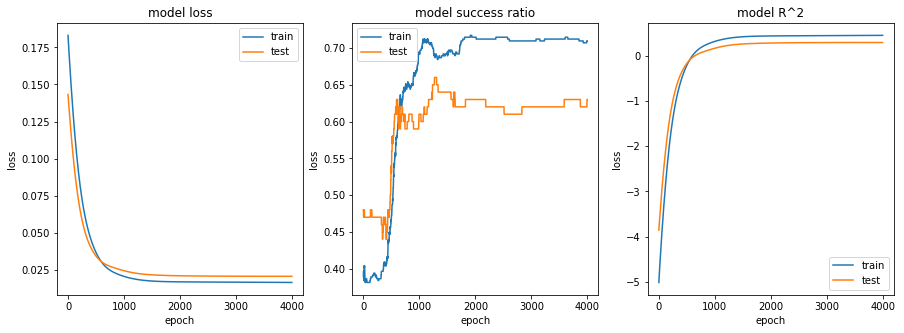

In [23]:
plt.figure(figsize=(15, 5)) 
plt.subplot(131)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

plt.subplot(132)
plt.plot(history.history['success_ratio'])
plt.plot(history.history['val_success_ratio']) 
plt.title('model success ratio') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

plt.subplot(133)
plt.plot(history.history['r_coeff'])
plt.plot(history.history['val_r_coeff']) 
plt.title('model R^2') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

In [24]:
# make predictions
keras_in_sample = model.predict(train_X)
keras_out_sample = model.predict(test_X)

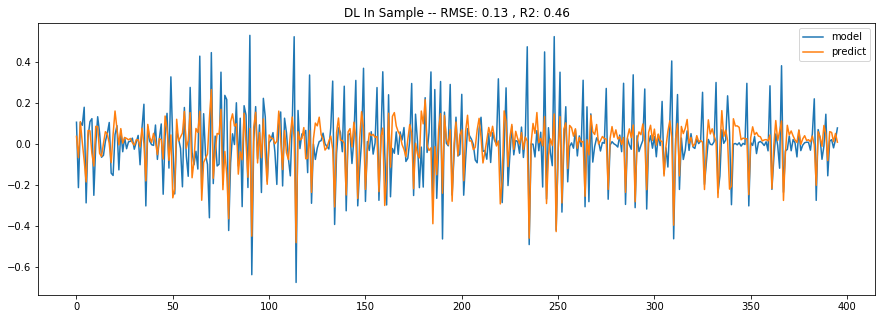

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(train_Y, label='model')
plt.plot(keras_in_sample, label='predict')
# calculate root mean squared error
rmse = np.sqrt(mean_squared_error(train_Y, keras_in_sample))
r2 = r2_score(train_Y, keras_in_sample)
plt.title('DL In Sample -- RMSE: %.2f , R2: %.2f' % (rmse, r2))
plt.legend(loc=0)
plt.show()

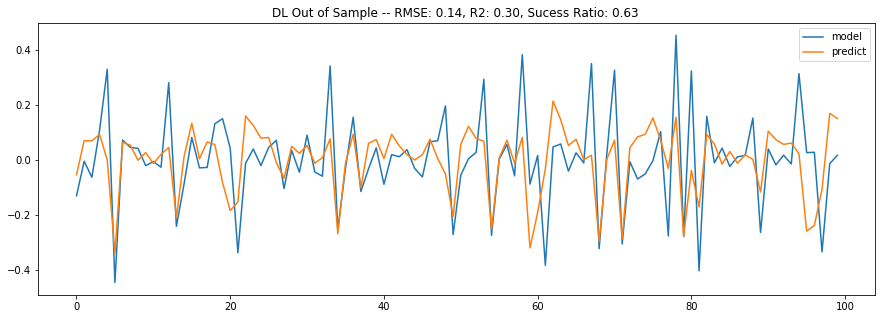

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(test_Y, label='model')
plt.plot(keras_out_sample, label='predict')
# calculate root mean squared error
rmse = np.sqrt(mean_squared_error(test_Y, keras_out_sample))
r2 = r2_score(test_Y, keras_out_sample)
# Success ratio
sr = np.mean(np.sign(keras_out_sample)==np.sign(test_Y))
plt.title('DL Out of Sample -- RMSE: %.2f, R2: %.2f, Sucess Ratio: %.2f ' % (rmse, r2, sr))
plt.legend(loc=0)
plt.show()